In [2]:
from ppget.source import ModelSource

start_date = "2007-07-01"
end_date = "2008-07-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [3]:
series = source.series()
series.head()

timestamp
2007-07-01 00:00:00    2.6812
2007-07-01 00:10:00    2.6502
2007-07-01 00:20:00    2.6266
2007-07-01 00:30:00    2.5242
2007-07-01 00:40:00    2.6000
Freq: 10T, Name: Global_active_power, dtype: float64

In [4]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 4
MODEL_NAME = "model/lstm/"

builder = DatasetBuilder(series, data_split=TrainSplit(), window_size=WINDOW)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((47430, 4, 1), (47430,), (5270, 4, 1), (5270,))

In [5]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Dense, LSTM
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(InputLayer((WINDOW, 1)))
model.add(LSTM(64, return_sequences=False, dropout=0.05))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))
callbacks = [ModelCheckpoint(MODEL_NAME, monitor="val_loss", save_best_only=True, mode="min"), EarlyStopping(patience=5, monitor="val_loss")]
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


2022-06-04 05:31:15.974486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
%%time
h = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=25,
                    batch_size=8,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)
print(f"min RMSE(validation): {min(h.history['val_loss'])}")

Epoch 1/25
4743/4743 - 15s - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
INFO:tensorflow:Assets written to: model/lstm/assets
Epoch 2/25
4743/4743 - 12s - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 3/25
4743/4743 - 10s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0596
Epoch 4/25
4743/4743 - 10s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 5/25
4743/4743 - 10s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 6/25
4743/4743 - 10s - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
min RMSE(validation): 0.003436682280153036
CPU times: user 2min 36s, sys: 40.4 s, total: 3min 17s
Wall time: 1min 8s


In [12]:
%%time
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

CPU times: user 2.18 s, sys: 107 ms, total: 2.29 s
Wall time: 2.15 s


5270

In [13]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results.head()

,Predictions,Ground Truth
0,0.081474,0.071953
1,0.077213,0.076587
2,0.083119,0.065371
3,0.069316,0.061949
4,0.067264,0.077062


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from pathlib import Path
import numpy as np

model_score = sqrt(mean_squared_error(test_results["Ground Truth"][:-1], test_results["Predictions"].shift(-1)[:-1]))
model_r2 = r2_score(test_results["Ground Truth"][:-1], test_results["Predictions"].shift(-1)[:-1])
model_size = sum(file.stat().st_size for file in Path(MODEL_NAME).rglob('*'))
print(f"Model Scores - (R2): {model_r2:.3f}, (RMSE): {builder.denormalise(np.array([model_score]))[0]:.3f} KW. Model Size - {model_size} bytes")

Model Scores - (R2): 0.974, (RMSE): 0.246 KW. Model Size - 831100 bytes


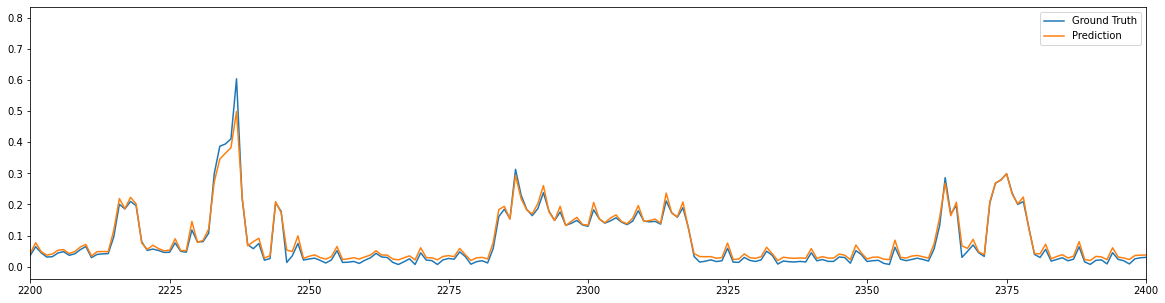

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_results["Ground Truth"], label="Ground Truth")
ax.plot(test_results["Predictions"].shift(-1), label="Prediction")

plt.legend(["Ground Truth", "Prediction"])
plt.xlim([2200, 2400])
plt.show()